In [1]:
import Pkg; Pkg.activate("../"); # Activate the project 

  Activating project at `~/Documents/Research/MonitoringMetrology/QuTaM.jl`


In [2]:
# Import all the necessary libraries
libraries = ["QuTaM", "LinearAlgebra", "Statistics", "Plots", "LaTeXStrings", "OrdinaryDiffEq"]

function ensure_imports(packages::Vector{String})
    for pkg in packages
        try
            @eval using $(Symbol(pkg))
        catch e
            if e isa ArgumentError && occursin(pkg, e.msg)
                println("Installing $pkg...")
                Pkg.add(pkg)
                @eval using $(Symbol(pkg))
            else
                rethrow(e)
            end
        end
    end
end

ensure_imports(libraries)

# Driven Qubit
The system of interest has hamiltonian:

$$ H = \frac{\Delta}{2} \sigma_z + \frac{\Omega}{2} \sigma_x$$

and jump operators

$$ L_1 = \sqrt{\gamma(\bar{n} +1 )}\sigma_- $$
$$ L_2 = \sqrt{\gamma\bar{n}}\sigma_- $$
(Wiseman, Equation 3.36)

## No drive nor Detuning Case $\Omega = 0, \Delta=0$
### Coordinates on the Bloch Sphere
$$ \dot{z}= -\gamma(2\bar{n}+1)(z + \frac{1}{2\bar{n}+1}) $$

In [69]:
########################## INITIALIZATION
# Define the hamiltonian
delta = 0.0 # Constant following Landi figure 7
gamma = 1
omega = 0.0
nbar = 0.5
H = 0.5*delta * QuTaM.sigma_z + 0.5*omega*QuTaM.sigma_x
# Define the jump operators
L1 = sqrt(gamma*(nbar+1))*QuTaM.sigma_m
L2 = sqrt(gamma*(nbar))*QuTaM.sigma_p
# Define the system
psi0 = zeros(ComplexF64, 2)
psi0[2] = 1
sys = System(H, [L1, L2])
params = SimulParameters(psi0,
    25.0, # Final time. Set very long so that all trajectories jump
    1, # seed
    1000, # Number of trajectories
    75_000, # Number of samples in the finegrid
    1.0, # Multiplier to use in the fine grid
    1e-3 # Tolerance for passing Dark state test
)

SimulParameters(psi0=ComplexF64[0.0 + 0.0im, 1.0 + 0.0im]
nsamples=75000
seed=1
ntraj=1000)
multiplier=1.0
tf=25.0
dt=0.0003333333333333333
eps=0.001)

In [70]:
# Analytical results
z0 = real(dot(psi0[:], QuTaM.sigma_z * psi0[:]))
z_an(t) = ( 1/(2*nbar+1) + z0)*Base.MathConstants.e^(-gamma*(2nbar+1)*t) - 1/(2*nbar+1)

z_an (generic function with 1 method)

In [71]:
# Generate trajectories
sample_clicks = run_trajectories(sys, params);

Sampling... 100%|████████████████████████████████████████| Time: 0:05:26


In [72]:
# Obtain states between jumps
ntimes = 10000
t = collect(LinRange(0, params.tf, ntimes))
sample_states = zeros(ComplexF64, ntimes, sys.NLEVELS, params.ntraj)
for k in 1:params.ntraj
    states_k = evaluate_at_t(t, sample_clicks[k], sys, psi0)
    for j in 1:sys.NLEVELS 
        for tn in 1:ntimes 
            sample_states[tn, j, k] = states_k[tn, j]
        end 
    end 
end 

In [73]:
# Evaluate the occupation number of the excited state
@time begin
sample_occupation_e = zeros(Float64, ntimes,  params.ntraj)
sample_occupation_g = zeros(Float64, ntimes,  params.ntraj)
sample_sigma_z = zeros(Float64, ntimes,  params.ntraj)
number_e = QuTaM.sigma_p * QuTaM.sigma_m
number_g = QuTaM.sigma_m * QuTaM.sigma_p
for k in 1:params.ntraj
    for tn in 1:ntimes 
        sample_occupation_e[tn, k] = dot(sample_states[tn, :, k], number_e * sample_states[tn, :, k])
        sample_occupation_g[tn, k] = dot(sample_states[tn, :, k], number_g * sample_states[tn, :, k])
        sample_sigma_z[tn, k] = dot(sample_states[tn, :, k], QuTaM.sigma_z * sample_states[tn, :, k])
    end 
end 
end

 32.410138 seconds (381.53 M allocations: 14.104 GiB, 5.43% gc time)


In [74]:
#Analyzing a given trajectory 
traj_index = 3
waiting_times = [click.time for click in sample_clicks[traj_index]] 
jump_times = cumsum(waiting_times)
times = Array{Float64}
jump_indeces = []
jump_labels = []
counter = 1
# Find the indices of the jumps
for t_jump in jump_times
    while (t[counter] < t_jump) && (counter < size(t)[1])
        counter = counter + 1
    end  
    if counter == size(t)[1]
        break
    end 
    push!(jump_indeces, counter)
end 

In [75]:
# Evaluate the net charge
traj = sample_clicks[3]
weights = [-1.0, 1.0]
function get_charge(t_given::Vector{Float64}, traj::Trajectory, weights::Vector{Float64})
    ntimes = size(t_given)[1]
    charge = zeros(Float64, ntimes)
    # Edge case: if the trajectory had no jumps, it has zero charge
    if isempty(traj)
        return charge
    end 
    njumps = size(traj)[1]
    wait_times = [click.time for click in traj] 
    jump_times = cumsum(wait_times)
    charge_counter = 0
    j_counter = 1
    t_counter = 1
    # Current for times before the final jump
    while j_counter < njumps
        while t_given[t_counter] < jump_times[j_counter]
            charge[t_counter] = charge_counter
            t_counter = t_counter + 1
            if t_counter > ntimes # if there are no more times, return
                return charge
            end 
        end 
        charge_counter = charge_counter + weights[traj[j_counter].label]
        j_counter = j_counter + 1
    end 
    # After the final jump 
    charge[t_counter:end] .= charge_counter
    return charge
end 

get_charge (generic function with 1 method)

In [76]:
# Obtain the current
current_sample = zeros(Float64, ntimes, params.ntraj)
for k in 1:params.ntraj
    charge = get_charge(t, sample_clicks[k], weights)
    for tn in 2:ntimes
        current_sample[tn, k] = (charge[tn] -  charge[tn-1]) # WARNING: THIS IS NOT NORMALIZED 
    end 
end 

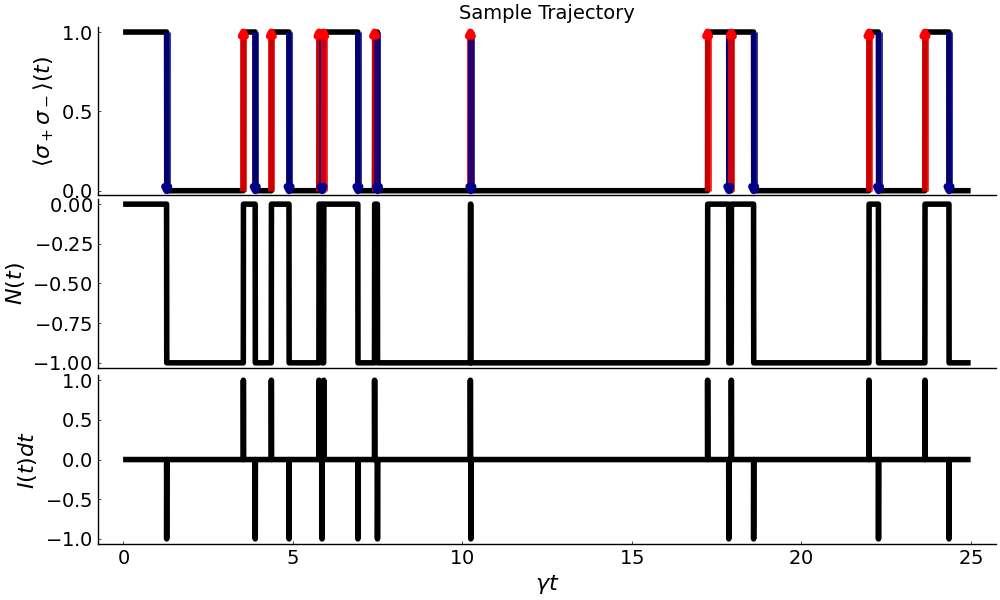

In [77]:
# Plot
pyplot()
charge_sample = get_charge(t, traj, weights)
p = plot(t, sample_occupation_e[:, traj_index], legend=false, linewidth=4, color="black",
             guidefont=font(16), grid=:false, gridalpha = 0.5, 
            ylabel = L"\langle\sigma_+\sigma_-\rangle(t)", title="Sample Trajectory", xticks=false,
            bottom_margin=0*Plots.mm, tickfont=font(14), yticks=[0.0, 0.5, 1.0])
# Add jump indicators
for j in jump_indeces
    if sample_occupation_e[j-1, traj_index] > sample_occupation_e[j+1, traj_index]
        plot!([t[j], t[j]], [sample_occupation_e[j-1, traj_index], sample_occupation_e[j+1, traj_index]],
              linewidth=5, alpha=0.8, color="darkblue", 
              arrow=:true, arrowsize=49)
    elseif sample_occupation_e[j-1, traj_index] < sample_occupation_e[j+0, traj_index]
        plot!([t[j], t[j]], [sample_occupation_e[j-1, traj_index], sample_occupation_e[j+1, traj_index]],
              linewidth=5, alpha=0.8, color="red", 
              arrow=:true, arrowsize=49)
    end 
end 
charge_plot = plot(t, charge_sample , color="black", linewidth=4, grid=:false, gridalpha = 0.5,
                    xticks=false, guidefont=(16), ylabel=L"N(t)", legend=:false)

current_plot = plot(t, current_sample[:, 3] , color="black", linewidth=4, grid=:false, gridalpha = 0.5,
                    xlabel=L"\gamma t", guidefont=(16), ylabel=L"I(t)dt", legend=:false)
plot(p, charge_plot ,current_plot, layout=(3,1), size=(1000, 600), tickfont=font(14))

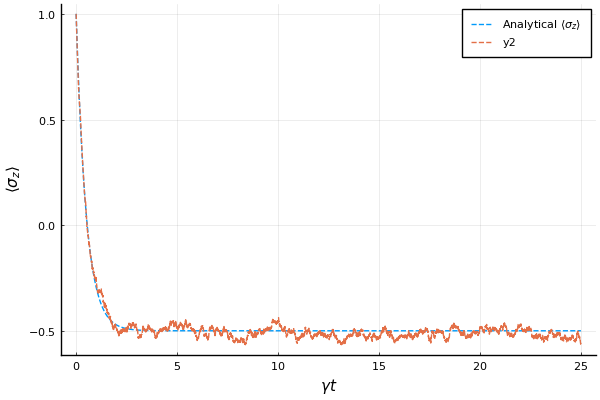

In [78]:
excited_population = dropdims(mean(sample_occupation_e, dims=2), dims=2)
ground_population = dropdims(mean(sample_occupation_g, dims=2), dims=2)
sz = dropdims(mean(sample_sigma_z, dims=2), dims=2)
average_current = gamma*nbar*ground_population - gamma*(nbar+0)*excited_population
plot(t/gamma, z_an.(t), label= L"Analytical $\langle\sigma_z\rangle$", line=:dash)
plot!(t/gamma, sz, line=:dash, xlabel=L"\gamma t", ylabel=L"$\langle\sigma_z\rangle$", label="Trajectory Average")

# General Case
The general case has the equation in the bloch sphere:

$$ \dot{x} = -\frac{\gamma}{2}(2\bar{n}+1)x - \Delta y + 0 $$
$$ \dot{y} = \Delta x -\frac{\gamma}{2}(2\bar{n}+1)y - \Omega z$$
$$ \dot{z} = 0 + \Omega y -\gamma(2\bar{n}+1)z - \gamma $$

In [82]:
########################## INITIALIZATION
# Define the hamiltonian
delta = 1.43 
gamma = 1.0
omega = 1.3
nbar = 0.2
H = 0.5*delta * QuTaM.sigma_z + 0.5*omega*QuTaM.sigma_x
# Define the jump operators
L1 = sqrt(gamma*(nbar+1))*QuTaM.sigma_m
L2 = sqrt(gamma*(nbar))*QuTaM.sigma_p
# Define the system
psi0 = zeros(ComplexF64, 2)
psi0[1] = 1
sys = System(H, [L1, L2])
params = SimulParameters(psi0,
    25.0, 
    1, # seed
    250, # Number of trajectories
    100_000, # Number of samples in the finegrid
    4.0, # Multiplier to use in the fine grid
    1e-3 # Tolerance for passing Dark state test
)
################## Differential Equation of the Observables

function rf_de!(dr, r, p, t)
    dr[1] = -0.5*gamma*(2*nbar+1)*r[1] - delta*r[2]
    dr[2] = delta*r[1] - 0.5*gamma*(2*nbar+1)*r[2] - omega*r[3]
    dr[3] = omega*r[2] - gamma*(2*nbar+1)*r[3] - gamma
end

rf_de! (generic function with 1 method)

In [83]:
# Trajectory Sampling
sampled_trajectories = run_trajectories(sys, params);

Sampling... 100%|████████████████████████████████████████| Time: 0:01:06


In [84]:
# Lindblad Evolution of Observables
r0 = [0.0; 0.0; -1.0] # Initial Condition
tspan = (0.0, params.tf)
t_given = collect(LinRange(0, params.tf, 1000));

In [85]:
prob = ODEProblem(rf_de!, r0, tspan)
sol = solve(prob, reltol = 1e-6, saveat = t_given); 

In [86]:
# Obtain the states between jumps
ntimes = size(t_given)[1]
sample = zeros(ComplexF64, ntimes, sys.NLEVELS, params.ntraj)
for n in 1:params.ntraj
    states = QuTaM.evaluate_at_t(t_given, sampled_trajectories[n], sys,  params.psi0)
    for j in 1:sys.NLEVELS
        for tn in 1:ntimes
            sample[tn, j, n] = states[tn, j]
        end 
    end 
end
# Evaluate the observables
r_sample = zeros(Float64, ntimes, 3, params.ntraj)
sigma = [QuTaM.sigma_x, QuTaM.sigma_y, QuTaM.sigma_z]

@time begin
for j in 1:params.ntraj
    for k in 1:3
        for tn in 1:ntimes
                r_sample[tn, k, j] = dot(sample[tn, :, j], sigma[k] * sample[tn, :, j]) 
        end
    end
end 
end
# Average
r_avg = dropdims(mean(r_sample, dims=3), dims=3);

  0.894042 seconds (7.45 M allocations: 331.234 MiB, 8.12% gc time, 1.87% compilation time)


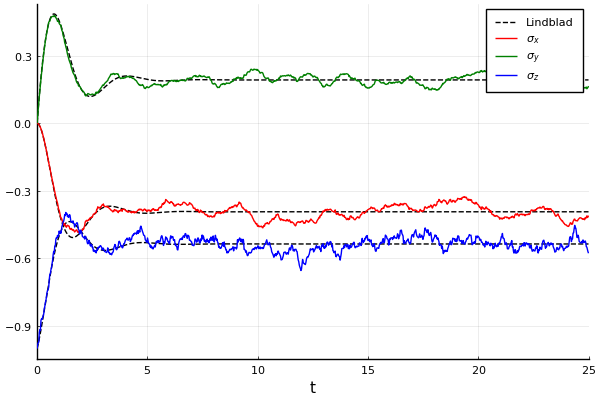

In [87]:
# Analytical
plot(sol, idxs =(0, 1), seriescolor="black", label="Lindblad",  line=:dash)
plot!(sol, idxs =(0, 2), seriescolor="black", label=:false,  line=:dash)
plot!(sol, idxs =(0, 3), seriescolor="black", label=:false,  line=:dash)
# Trajectory Average
plot!(t_given, r_avg[:, 1],  label=L"\sigma_x" , seriescolor=:red)
plot!(t_given, r_avg[:, 2],  label=L"\sigma_y" , seriescolor=:green)
plot!(t_given, r_avg[:, 3],  label=L"\sigma_z" , seriescolor=:blue)
